In [1]:
from Functions import *
import MetricMapping

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# from matplotlib.patches import Patch

In [2]:
# Access the mappings:
type_mapping = MetricMapping.type_mapping
name_mapping = MetricMapping.name_mapping

In [3]:
resolutions = ['', '_DMC_10']

In [4]:
transformed_minmax_scaled = pd.read_csv("../Data/NotScaled_RawVsDMC.csv")

In [5]:
transformed_minmax_scaled = pd.read_csv("../Data/NotScaled_RawVsDMC.csv")

for res in resolutions:

    transformed_minmax_scaled[f'peak_mean_ratio{res}'] = transformed_minmax_scaled[f'peak_mean_ratio_scaled{res}']
    transformed_minmax_scaled[f'relative_amp{res}'] = transformed_minmax_scaled[f'relative_amp_scaled{res}']
    del transformed_minmax_scaled[f'relative_amp_scaled{res}']
    del transformed_minmax_scaled[f'peak_mean_ratio_scaled{res}']

column_names = transformed_minmax_scaled.columns.str.replace('_log', '')
column_names = column_names.str.replace('_yj', '')
# column_names = column_names.str.replace('_wi', '')
transformed_minmax_scaled.columns = column_names

In [6]:
categorical_metrics = ['3rd_ARR',  '3rd_rcg',  '3rd_w_peak', '4th_w_peak', '5th_w_peak', 'third_ppr', '3rd_w_most', 
                       '4th_w_most', '5th_w_most']
continuous_metrics = [metric for metric in column_names if metric not in categorical_metrics]
# metric_base_names = {col.replace(suffix, '') for col in transformed_minmax_scaled.columns  for suffix in ['_DMC_10']  if col.endswith(suffix)}

In [7]:
summary_df = compute_metric_sensitivity_bynormalisation(df=transformed_minmax_scaled,
    continuous_metrics=continuous_metrics,
    categorical_metrics=categorical_metrics)
summary_df["type2"] = summary_df["metric"].map(type_mapping)

# Sort by type_2 and descending rank_corr
summary_df = summary_df.sort_values(
    by=["type2", "rank_corr"],
    key=lambda col: (
        col.map({'Asymmetry': 0, 'Peakiness': 1, 'Concentration': 2, 'Intermittency': 3})
        if col.name == "type2" else -col))

In [8]:
df_intermittency = summary_df[summary_df["type2"] == "Intermittency"]
df_other = summary_df[(summary_df["type2"] != "Intermittency") & (summary_df["type"] != "categorical")]
df_categorical = summary_df[summary_df["type"] == "categorical"]

In [57]:
metric_data

,metric,resolution,type,rank_corr,val_diff,gini,type2
19,intermittency,DMC_10,continuous,0.410104,154.266877,0.467334,Intermittency


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bin_edges
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


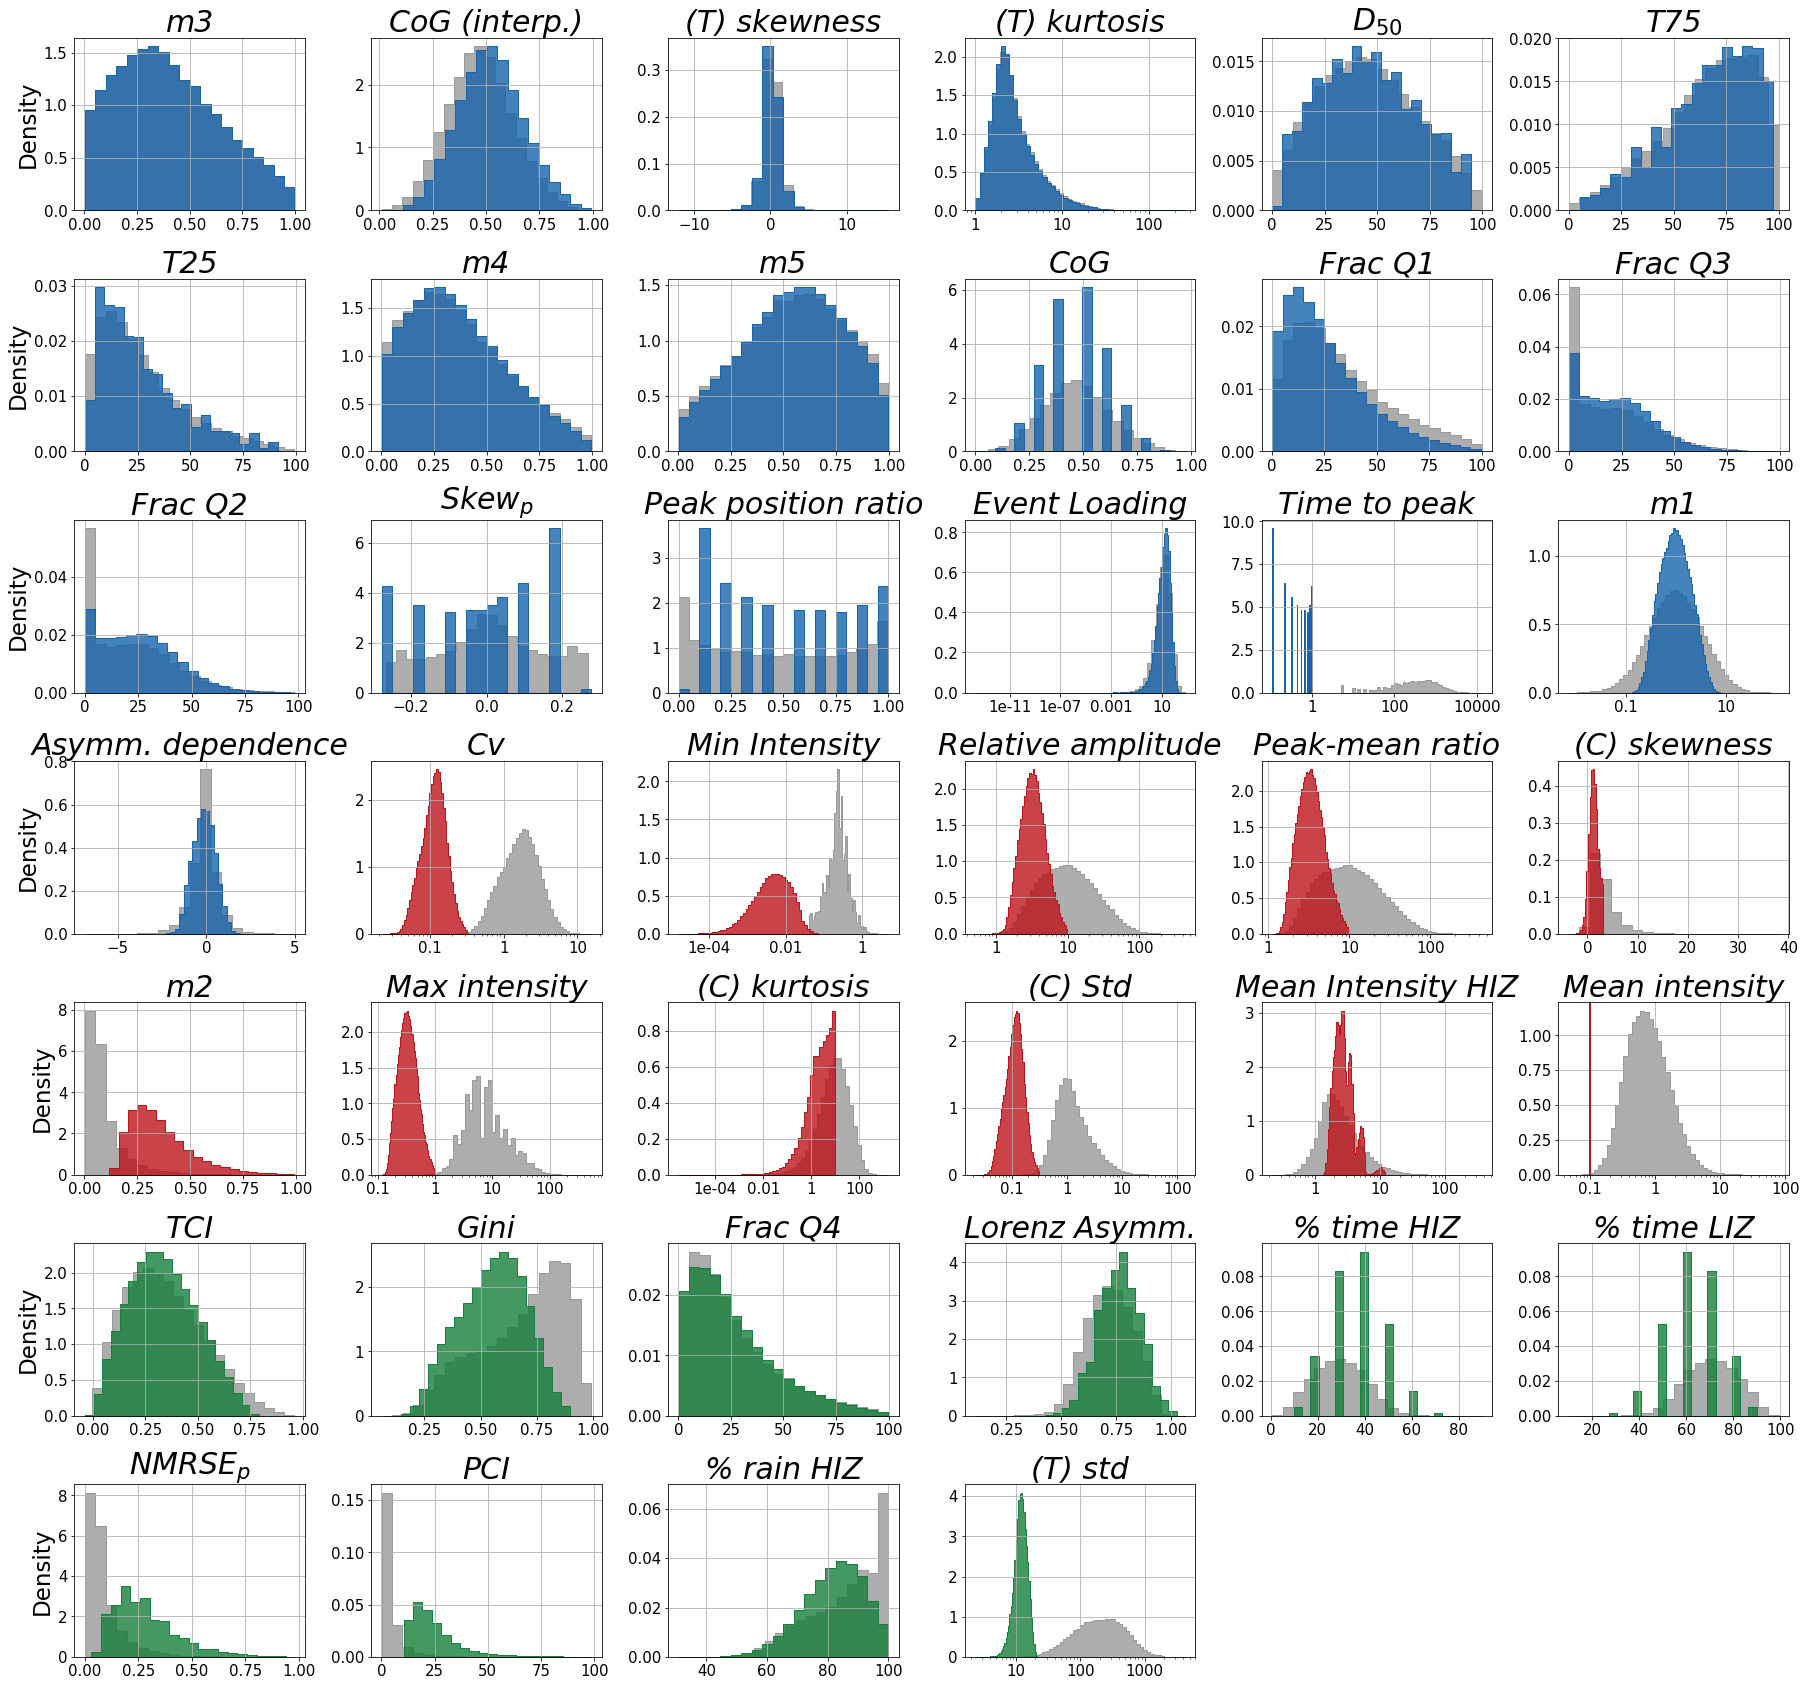

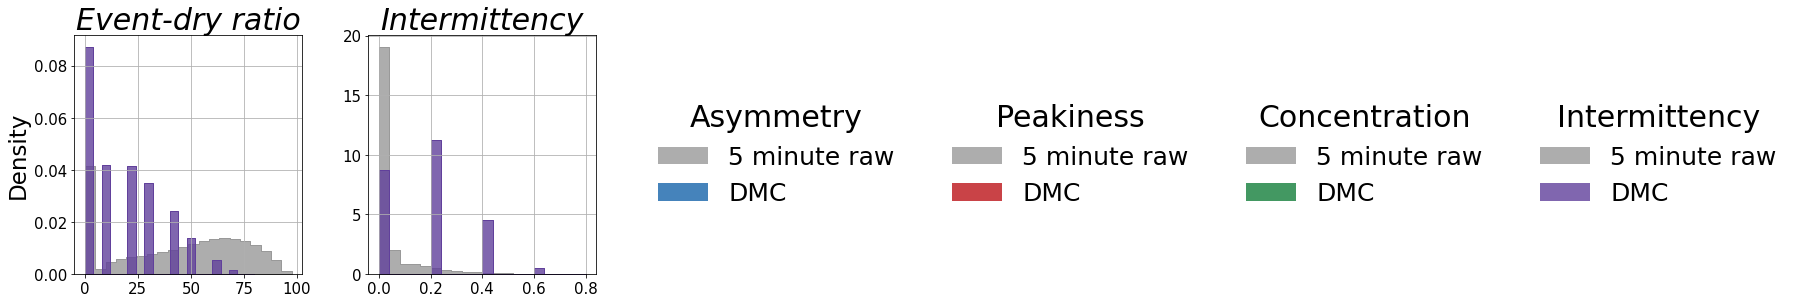

In [63]:
log_scale_metrics = ['mean_intensity', 'time_to_peak', 'std', 'Mean Intensity HIZ', 'm1', 'm1_wi', 'cv', 'time_kurtosis',
                    'max_intensity', 'mean_intensity', 'kurtosis', 'relative_amp', 'peak_mean_ratio', 'Event Loading',
                    'min_intensity', 'time_std']

separate_bin_metrics = ['cv', 'm1', 'time_to_peak', "kurtosis", "max_intensity", "std", 'mean_intensity']


unique_metrics_main = df_other["metric"].unique()
n_cols_main = 6
n_rows_main = -(-len(unique_metrics_main) // n_cols_main)

fig_main, axs_main = plt.subplots(ncols=n_cols_main, nrows=n_rows_main,
                                  figsize=(4.2 * n_cols_main, 3.5 * n_rows_main),
                                  sharex=False, sharey=False)
axs_main = axs_main.flatten()

# Track max/min values for autoscaled limits
x_min, x_max, y_min, y_max = float('inf'), float('-inf'), float('inf'), float('-inf')


for i, this_metric in enumerate(unique_metrics_main):
    if this_metric not in ['mean_intensity']:
        ax = axs_main[i]
        metric_data = df_other[df_other["metric"] == this_metric]
        plot_histograms(ax,transformed_minmax_scaled, this_metric, metric_data, log_scale_metrics, type_color_map_3, resolutions)
    else:
        ax = axs_main[i]
        metric_data = df_other[df_other["metric"] == this_metric]
        plot_histograms(ax,transformed_minmax_scaled, this_metric, metric_data, log_scale_metrics, type_color_map_3, resolutions)
        ax.axvline(x=0.1, color=type_color_map_3['Peakiness'][1], linewidth=2)
        
for ax in axs_main[len(unique_metrics_main):]:
    ax.axis('off')
    
for i, ax in enumerate(axs_main):
    if i % n_cols_main == 0:  # First column in each row
        ax.set_ylabel('Density', fontsize=23)
    else:
        ax.set_ylabel('')        

# fig_main.suptitle("Summary statistics (Asymmetry, Peakiness, Concentration)", fontsize=25)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

fig_main.savefig("../Figures/histograms_main_DMC10.png", dpi=300, facecolor='white')

# --- PLOT 2: Intermittency Figure ---
if not df_intermittency.empty:
    unique_metrics_int = df_intermittency["metric"].unique()
    n_cols_int = 6
    n_rows_int = -(-len(unique_metrics_int) // n_cols_int)

    fig_int, axs_int = plt.subplots(ncols=n_cols_int, nrows=n_rows_int,
                                    figsize=(4.2 * n_cols_int, 4.5 * n_rows_int),
                                    sharex=False, sharey=False)
    axs_int = axs_int.flatten()

    # Plot each metric
    for i, this_metric in enumerate(unique_metrics_int):
        ax = axs_int[i]
        metric_data = df_intermittency[df_intermittency["metric"] == this_metric]
        plot_histograms(ax,transformed_minmax_scaled, this_metric, metric_data, log_scale_metrics, type_color_map_3, resolutions)

    legend_types = list(type_color_map_3.keys())
    legend_axes_start = len(unique_metrics_int)  # first free subplot
    
    labels = ['5 minute raw', 'DMC']
    
    for i, metric_type in enumerate(legend_types):
        idx = legend_axes_start + i
        if idx < len(axs_int):
            ax_legend = axs_int[idx]
            ax_legend.axis('off')
            colors = type_color_map_3[metric_type]
            patches = [Patch(facecolor=colors[j], label=labels[j], alpha=0.8) for j in range(len(resolutions))]
            ax_legend.legend(handles=patches, title=metric_type, loc='center', frameon=False, ncol=1, handlelength=2,
                             fontsize=25, title_fontsize =30)

    # Turn off any remaining unused axes after legend
    for ax in axs_int[legend_axes_start + len(legend_types):]:
        ax.axis('off')
        
    for i, ax in enumerate(axs_int):
        if i % n_cols_int == 0:  # First column in each row
            ax.set_ylabel('Density', fontsize=23)
        else:
            ax.set_ylabel('')
            
#     fig_int.suptitle("Intermittency metrics", fontsize=25)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    fig_int.savefig("../Figures/histograms_intermittency_DMC10.png", dpi=300, facecolor='white')

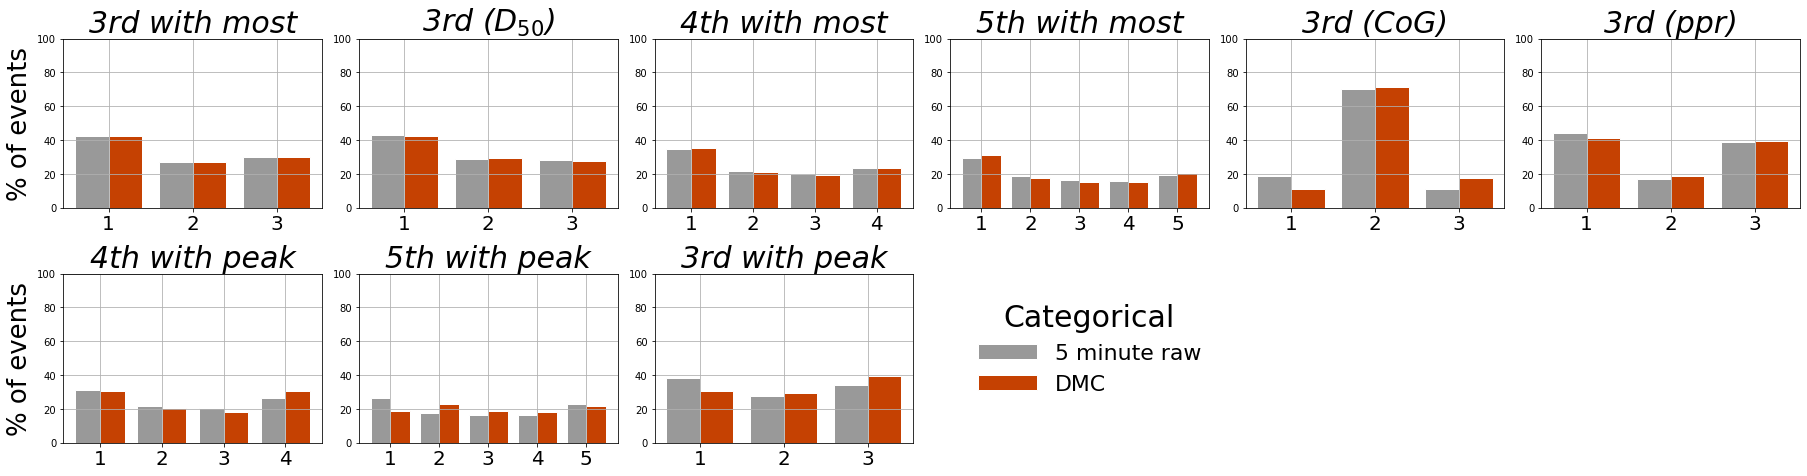

In [53]:
# --- now make your grid of small multiples ---
unique_metrics =df_categorical['metric'].unique().tolist()
n_cols = 6
n_rows = -(-len(unique_metrics) // n_cols)
fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(4.2 * n_cols, 3.5 * n_rows), sharex=False, sharey=False)
axs = axs.flatten()

for i, metric in enumerate(unique_metrics):
    plot_grouped_categorical(
        axs[i],
        metric,
        transformed_minmax_scaled,
        type_color_map_3, resolutions)

# turn off any unused axes
for ax in axs[len(unique_metrics):]:
    ax.axis('off')

for i, ax in enumerate(axs):
    if i % n_cols == 0:  # First column in each row
        ax.set_ylabel('% of events', fontsize=26)
    else:
        ax.set_ylabel('')    

# Create custom legend handles using the palette
palette = type_color_map_3['Categorical']
labels = ['5 minute raw', 'DMC']
legend_handles = [Patch(facecolor=palette[i], edgecolor='white', label=labels[i], alpha=1)
    for i, res in enumerate(labels)]

fig.legend(handles=legend_handles,
    labels=labels,
    title="Categorical",
     frameon=False,
    title_fontsize=30,    # larger title
    fontsize=22,          # larger labels
    bbox_to_anchor=(0.53, 0.26),
    loc='center left',
    labelspacing=0.5,     # space between labels
    handlelength=2.7,     # length of color boxes
    handletextpad=0.8)


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
fig.savefig("../Figures/grouped_categorical_metrics_DMC10.png", dpi=300, facecolor='white')